# **NLG Hallucination Detection**

Hallucinations are when a model confidently presents an incorrect or unfactual response to an end user. They are the most popular critizism and risk assosiated with LLMs and natural language generation. Preventing Halluncinations is critical for user safety and application adoption.
  
In general, there are two categories of hallucination prevention:
1. Mitigation: Prevention methods before a response is generated using techniques like Prompt Engineering ("Say I don't know") or RAG
2. Detection: Analyzing the response after it is generated. These can be used in-line to prevent a hallucenated response from being presented to a user

**This notebook** will use Azure PromptFlow to implement 3 techniques of **_halluncination  detection_**. There methods can be used _inline_ with chat or Q&A response to screen responses for hallucinations before being presented to the user. The methods utilized in this notebook are as follows:
1. **Hughes Hallucination Evaluation Model**: Open source Hugues Hallucination Evaluation model (fine-tuned-deberta-v3-base) model for hallucination detection 
2. **Natural Language Inference (NLI) Contradiction Score**: Nli-deberta-v3-base OOS language model to detect contradictions
3. **ChainPoll**: Make multiple calls to GPT4 to poll for halluncination likelihood

Other common hallucination detection methods, such as self-consistency CoT (Chaine of Thought) scoring or SelfCheckGPT, use a sampling method requiring the scoring of multiple LLM generated responses to the same question. This notebook excludes those methods as generating 3-5 responses per question linearly scales token gen. and cost, making solutions like these not viable at scale.

**_Dataset_**
The notebook will use a subsample of the [wiki_bio_gpt3_hallucination](https://huggingface.co/datasets/potsawee/wiki_bio_gpt3_hallucination) human labeled dataset, available on hugging face, to assess hallucination detection results. 

**_Go Deeper_**  
    
- HHEM: [Hughes Hallucination Evaluation Model (HHEM)](https://huggingface.co/vectara/hallucination_evaluation_model)  
- Contradiction Scoring: [With a Little Push, NLI Models can Robustly and Efficiently Predict Faithfulness](https://arxiv.org/pdf/2305.16819.pdf)  
- ChainPoll: [ChainPoll: A High Efficacy Method for LLM Hallucination Detection](https://arxiv.org/pdf/2310.18344v1.pdf)  
  
**_Prerequisites_**  
  
- Ensure that your environment is setup by completing the steps outlines in [0_setup.ipynb](./0_setup.ipynb)

In [ ]:
# Import libraries

from azure.ai.ml import MLClient
from azure.identity import DefaultAzureCredential
from datasets import load_dataset
from dotenv import load_dotenv, find_dotenv
from sklearn.metrics import precision_score, recall_score
import pandas as pd
import plotly.express as px
import os

In [ ]:
# Get handle to workspace
load_dotenv(find_dotenv(), override=True)
print(os.getenv("WORKSPACE_NAME"))

# authenticate
credential = DefaultAzureCredential()

# Get a handle to the workspace
ml_client = MLClient(
    credential=credential,
    subscription_id = os.environ.get('SUBSCRIPTION_ID'),
    resource_group_name = os.environ.get('RESOURCE_GROUP_NAME'),
    workspace_name = os.environ.get('WORKSPACE_NAME'),
)

## Load and Process Input Data

In [ ]:
# Load dataset
wiki_bio = load_dataset("potsawee/wiki_bio_gpt3_hallucination")['evaluation']

# Get subsample
wiki_bio_sample = wiki_bio.filter(lambda wiki_bio, idx: idx % 10 == 0, with_indices=True)

# Convert to pandas
wiki_bio_sample_df = wiki_bio_sample.to_pandas()
display(len(wiki_bio_sample_df))

# Add baseline label column
wiki_bio_sample_df["label"] = 0

display(wiki_bio_sample_df.dtypes)

In [ ]:
# Process Data
level = "major_inaccurate" # change to "minor_inaccurate" if you want to include minor inaccuracies


def trim_samples(samples):
    # Trim gpt3_text_samples from 20 to 5
    return samples[:5]

def code_annotations(annotations):
    # Convert to singular binary hallucination classifier
    # If annotation contains (major_inaccurate/minor_inaccurate) then label as 1
    for note in annotations:
        if note == level:
            return 1
    return 0

wiki_bio_sample_df["gpt3_text_samples"] = wiki_bio_sample_df["gpt3_text_samples"].apply(lambda x : trim_samples(x))
wiki_bio_sample_df["gpt3_text_sample_size"] = wiki_bio_sample_df["gpt3_text_samples"].apply(lambda x : len(x)) # validation trim_samples works
wiki_bio_sample_df['label'] = wiki_bio_sample_df['annotation'].apply(lambda x: code_annotations(x))

# Drop index and original annotation
wiki_bio_sample_df = wiki_bio_sample_df.drop(columns=['annotation', 'wiki_bio_test_idx'])

# Write to output folder as jsonl
wiki_bio_sample_df.to_json("../data/inputs/wiki_bio_gpt3_hallucination.jsonl", orient="records", lines=True)

display(wiki_bio_sample_df.head(5))

## Setup nli-deberta-v3-base fine tuned contradiction classification model

- Navigate to the Azure Machine Learning model catolog and search "cross-encoder-nli-deberta-v3-small, hit "Deploy", and follow the UI workflow to deploy the model [(Link)](https://ml.azure.com/models/cross-encoder-nli-deberta-v3-small/version/6/catalog/registry/HuggingFace?wsid=/subscriptions/9a729243-1221-42c5-824c-9e44cb2da98d/resourcegroups/nlg-eval-rg/providers/Microsoft.MachineLearningServices/workspaces/nlg-eval-aml&tid=16b3c013-d300-468d-ac64-7eda0820b6d3)  
  - [Hugging Face Documentation](cross-encoder/nli-deberta-v3-small)
  - _Note: We opted to use the 'small' version of the model for this demo for cost considerations. The base version of the model is slightly more performant_  
  
  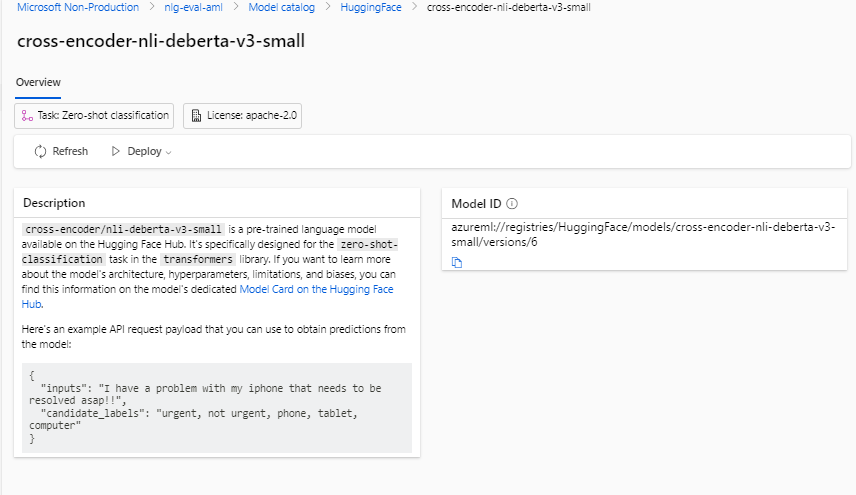


- You should end up with an endpoint and deployment like so:  
   
  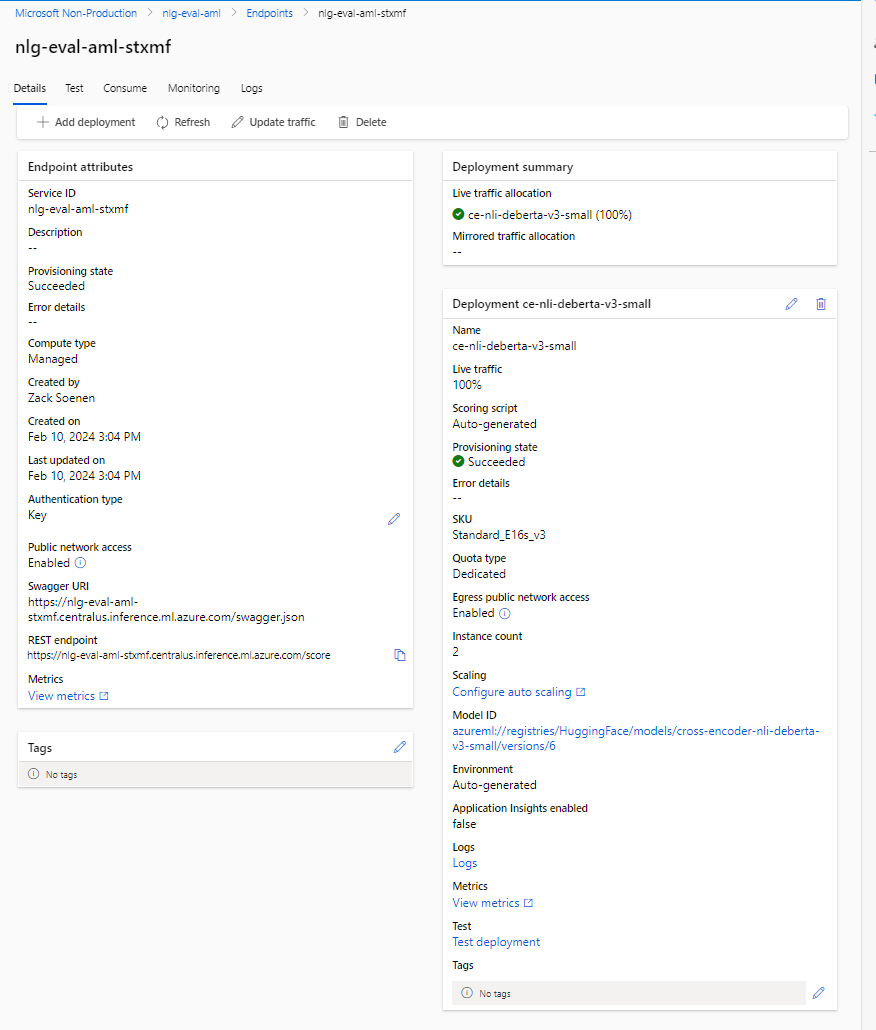

- Copy and Past the API KEY and BASE URL into you _.env_ file and reload your environment variables by running the second code cell in this notebook

## Run Hallucination Detection w/ Azure PromptFlow
- Take a look at the PromptFlow in detail here: [Hallucination Detection Flow](../src/promptflow/evaluation_flows/hallucination_detection/)
  
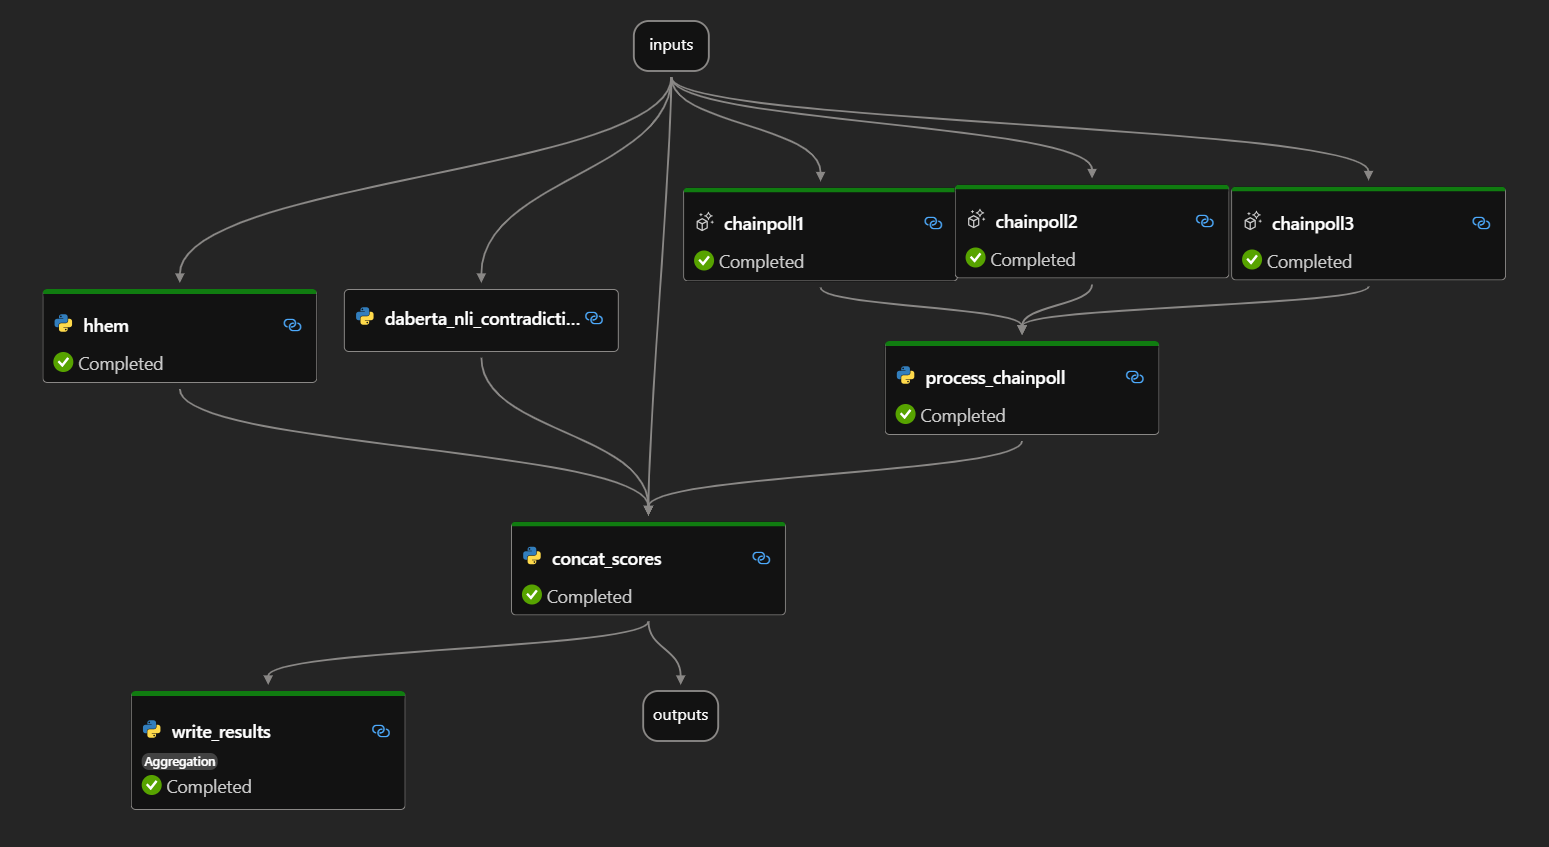

In [ ]:
from promptflow import PFClient

# PFClient can help manage your runs and connections.
pf = PFClient()

# Define Flows and Data
halu_detect = "../src/promptflow/evaluation_flows/hallucination_detection" # set the flow directory
# data =  "../data/inputs/haluEval.jsonl" # set the data file
data = "../data/inputs/wiki_bio_gpt3_hallucination.jsonl"

# Run chat flow to generate chat results
halu_detect_run = pf.run(
    flow=halu_detect,
    data=data,
    stream=False,
    environemnt_variables = {
        "TOKENIZERS_PARALLELISM": "FALSE",
        "DEBERTA_API_KEY": os.environ.get("DEBERTA_API_KEY"),
        "DEBERTA_API_BASE": os.environ.get("DEBERTA_API_BASE"),
        },
    column_mapping={  # map the url field from the data to the url input of the flow
      "response": "${data.gpt3_text}",
      "context": "${data.wiki_bio_text}",
      "human_label": "${data.label}"
    }
) 

## Analyze Results

In [ ]:
import pandas as pd
output_data = "../data/outputs/hallucination_detection.json"

output_df = pd.read_json(output_data)
display(output_df.head(5))

In [ ]:
# Encode outputs to binary classification 
# 1 = hallucination and 0 = no hallucination

# Adjust Thresholds here:
hhem_threshold = 0.5
chain_poll_threshold = 0.5
nli_score_threshold = 0.5

# Code variables
output_df["hhem_score"] = output_df["hhem_score"].apply(lambda x: 1 if x < hhem_threshold else 0)
output_df["chain_poll"] = output_df["chain_poll"].apply(lambda x: 1 if x > chain_poll_threshold else 0)
output_df["nli_score"] = output_df["nli_score"].apply(lambda x: 1 if x > nli_score_threshold else 0)

display(output_df)

In [ ]:
# Calculate each metrics recall vs human labeled
metric_columns = ["hhem_score", "chain_poll", "nli_score"]
precisions = []
recalls = []

for metric in metric_columns:
    precisions.append(precision_score(output_df["human_label"], output_df[metric]))
    recalls.append(recall_score(output_df["human_label"], output_df[metric]))
    

metric_df = pd.DataFrame({"metric": metric_columns, "precision": precisions, "recall": recalls})
display(metric_df)

In [ ]:
# Graph the results
fig = px.bar(metric_df, x="metric", y=['precision','recall'], barmode='group')
fig.show()

## Analyze Performance and Latency

Since performance is critically important for inline hallucination detection. You can utilize Azure PromptFlows built in profiler to assess the performance of each function and identify potential efficiencies. For example, in the screenshot below, each function delivers results in between 0.3 and 1.3 seconds.  
  
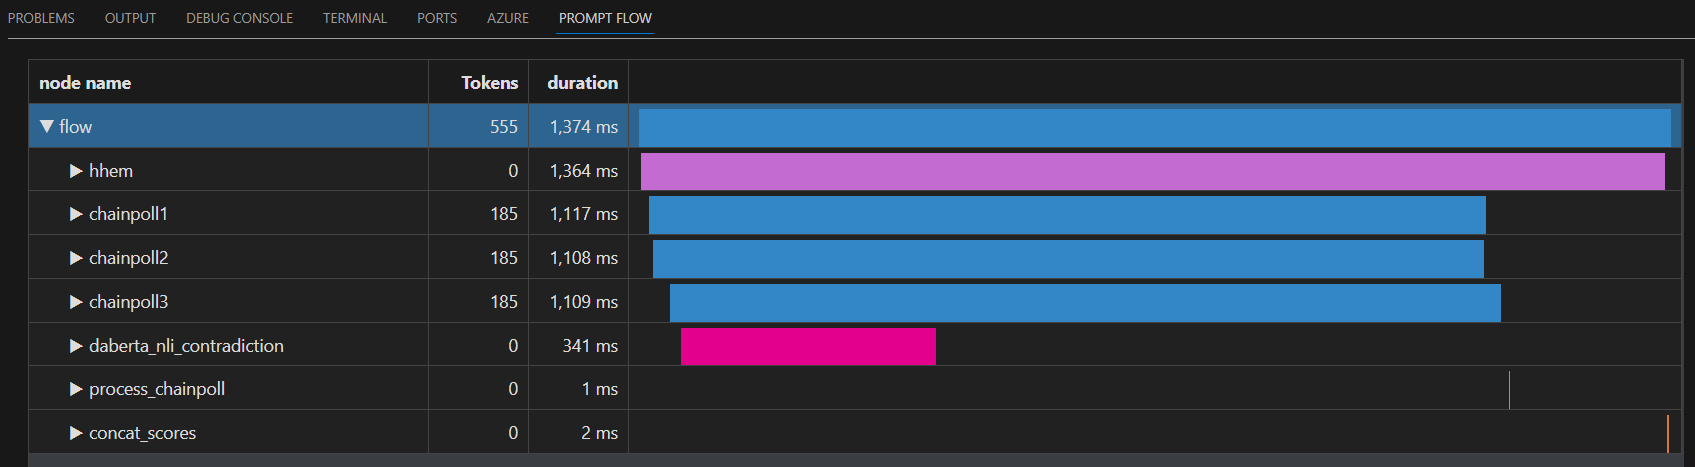

## 5. Clean-Up  

To avoid unecessary costs, tear down the nli-deberta-v3-base model endpoint and deployment via the Azure portal.  
  
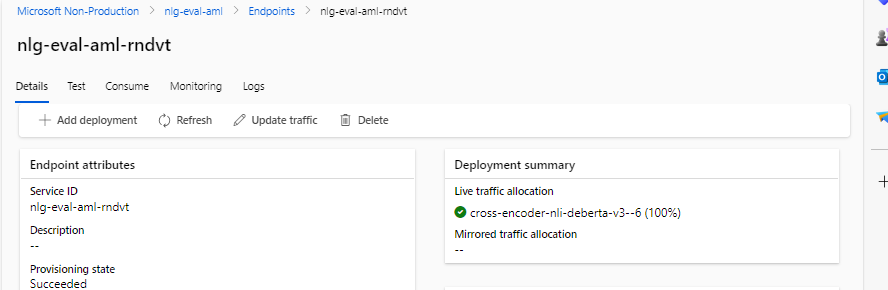